# Cleaning and splitting NIST
This notebook differs from the original one by FILIP JOZEFOV in two steps:
- removing stereochemistry before the split
- canonizing smiles before the split

Since there is no deduplication, these steps are important for not having data leaks (same molecules in different splits) across the splits

In [1]:
from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp
from matchms import Spectrum
import matchms

import pandas as pd
from rdkit import Chem

import math
import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
FILE_PATH = 'datasets/NIST/NIST20/20210925_NIST_EI_MS_cleaned.msp'

In [3]:
nist_dataset = list(load_from_msp(FILE_PATH, metadata_harmonization=False))

Setting random seed for reproducible result

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
nist_dataset[0].metadata

{'formula': 'H2',
 'casno': '1333-74-0',
 'id': '1',
 'comment': 'NIST MS# 245692, Seq# M1',
 'inchi': 'InChI=1S/H2/h1H',
 'inchikey': 'UFHFLCQGNIYNRP-UHFFFAOYSA-N',
 'iupac_name': 'molecular hydrogen',
 'smiles': '[HH]',
 'num_peaks': '2',
 'compound_name': 'Hydrogen',
 'nominal_mass': '2'}

In [6]:
# test - how many spectra have chirality information
def compute_chirality(dataset):
    counter = 0
    for s in dataset:
        if s.get('smiles') and "@" in s.get('smiles'):
            counter += 1
    print(f"Number of spectra with chirality information: {counter}")

compute_chirality(nist_dataset)

Number of spectra with chirality information: 433


In [7]:
# test - how many smiles (from those spectra with a valid smiles) are non canonical
# the number in the original dataset is 251878
def compute_non_canonical(dataset):
    counter = 0
    for s in tqdm(dataset):
        if s.get('smiles'):
            mol = Chem.MolFromSmiles(s.get('smiles'))
            if mol and Chem.MolToSmiles(mol) != s.get('smiles'):
                counter += 1
    print(f"Number of spectra with a valid but non-canonical smiles: {counter}")

compute_non_canonical(nist_dataset)

  0%|          | 0/350618 [00:00<?, ?it/s][15:42:06] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:42:06] Explicit valence for atom # 1 Cl, 4, is greater than permitted
  7%|▋         | 24712/350618 [00:03<00:48, 6676.00it/s][15:42:10] Explicit valence for atom # 0 B, 6, is greater than permitted
[15:42:10] Explicit valence for atom # 0 B, 5, is greater than permitted
 17%|█▋        | 59560/350618 [00:09<00:48, 5981.32it/s][15:42:16] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[15:42:16] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
 18%|█▊        | 62040/350618 [00:09<00:48, 6004.37it/s][15:42:16] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[15:42:16] SMIL

Number of spectra with a valid but non-canonical smiles: 251878


In [8]:
# function for making smiles canonical and removing stereochemistry
# fla
def remove_stereochemistry_and_canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)    # canonize smiles
    if mol is not None:                           # TODO oddelej if else 
        Chem.RemoveStereochemistry(mol)
    else: 
        return None   # desteorechem
    new_smiles = Chem.MolToSmiles(mol)    # convert to smiles
    return new_smiles

In [9]:
# count examined occurrences of specific data missing in our dataset

def count_all(dataset):
    
    all_data = 0

    no_smiles = 0
    no_inchikey = 0
    no_inchi = 0

    no_smile_only = 0
    no_inchikey_only = 0
    both_missing_counter = 0

    all_identifier_missing = 0

    for obj in dataset:
        if obj.get('smiles') == None:
            no_smiles += 1
        if obj.get('inchikey') == None:
            no_inchikey += 1
        if obj.get('inchi') == None:
            no_inchi += 1
        if obj.get('smiles') == None and obj.get('inchi') != None:
            no_smile_only += 1
        if obj.get('smiles') != None and obj.get('inchi') == None:
            no_inchikey_only += 1
        if obj.get('smiles') == None and obj.get('inchikey') != None:
            both_missing_counter += 1
        if obj.get('smiles') == None and obj.get('inchikey') == None and obj.get('inchi') == None:
            all_identifier_missing += 1
        all_data += 1
    return (all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,
            both_missing_counter, all_identifier_missing)

In [10]:
# storing all occurences for smiles, inchi, inchikey and formula
def get_all_identifiers(dataset):
    
    inchikey = []
    inchi = []
    smiles = []
    formulas = [] 
    for obj in dataset:
        inchikey.append(obj.get('inchikey'))
        inchi.append(obj.get('inchi'))
        smiles.append(obj.get('smiles'))
        formulas.append(obj.get('formula'))
    
    return (inchikey, inchi, smiles, formulas)

In [11]:
all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing = count_all(nist_dataset)

In [12]:
inchikey, inchi, smiles, formulas = get_all_identifiers(nist_dataset)

In [13]:

print(f"We are currently working with {len(smiles)} smiles, from which {len(set(smiles))} are unique", end="\n\n")
print(f"We are currently working with {len(inchikey)} inchikeys, from which {len(set(inchikey))} are unique", end="\n\n")
print(f"We are currently working with {len(inchi)} inchi, from which {len(set(inchi))} are unique", end="\n\n")
print(f"We are currently working with {len(formulas)} formulas, from which {len(set(formulas))} are unique", end="\n\n")

We are currently working with 350618 smiles, from which 243549 are unique

We are currently working with 350618 inchikeys, from which 246911 are unique

We are currently working with 350618 inchi, from which 246458 are unique

We are currently working with 350618 formulas, from which 82741 are unique



In [14]:
data_missing = {
    'All data': [all_data],
    'No smiles': [no_smiles],
    'No inchikey': [no_inchikey],     
    'No inchi': [no_inchi],
    'Smiles Only Missing': [no_smile_only],
    'Inchi Only Missing': [no_inchikey_only],
    'Both Missing': [both_missing_counter],
    'All tree missing': [all_identifier_missing],    
}
missing_df = pd.DataFrame(data_missing)

In [15]:
missing_df = missing_df.T
missing_df.columns = ["Count"]
missing_df["average"] = missing_df.apply(lambda row: row.Count / all_data, axis = 1)

We have approximately 60k data that we are unable to work with. They do not include identifiers in any inchi, inchikey, or smiles. Proceeding, we will try to obtain some more smiles and, if possible correct corrupted ones.

In [16]:
missing_df

,Count,average
All data,350618,1.000000
No smiles,60494,0.172535
No inchikey,60163,0.171591
No inchi,60757,0.173285
Smiles Only Missing,191,0.000545
Inchi Only Missing,454,0.001295
Both Missing,334,0.000953
All tree missing,60160,0.171583


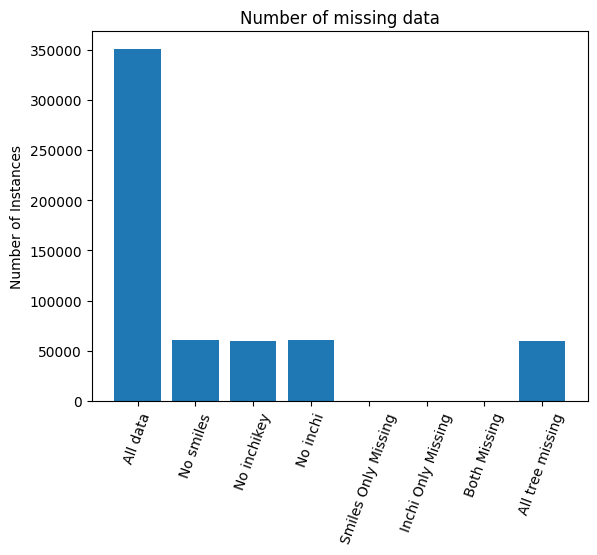

In [17]:
# x-coordinates of left sides of bars 
parameters_missing = [i for i in range(len(missing_df))]
  
# heights of bars
height = [i for i in missing_df.Count]
  
# labels for bars
tick_label = ['All data', 'No smiles', 'No inchikey', 'No inchi', 'Smiles Only Missing',
              'Inchi Only Missing', 'Both Missing', 'All tree missing']
  

plt.bar(parameters_missing, height, tick_label = tick_label,
        width = 0.8)
  
plt.xlabel('')
plt.xticks(rotation=70)
plt.ylabel('Number of Instances')
plt.title('Number of missing data')
plt.show()

# Data preparing

In [18]:
# Filter and try to restore corupted smiles
# both tools are used, with help of rdkit and matchms as well
# OKAY, here we add the smiles destereo and canonization

def refill_information(dataset):
    counter_smiles_changed = 0
    updated_nist = []
    for spectrum in tqdm(dataset):
        smiles = spectrum.get('smiles')
        # all missing
        if smiles == None and spectrum.get('inchikey') == None and spectrum.get('inchi') == None:
            continue
            
        #check weather smiles is syntactically valid or molecule is chemically reasonable
        if (smiles == None or \
            Chem.MolFromSmiles(smiles, sanitize=False) == None or\
            Chem.MolFromSmiles(smiles) == None) and\
            spectrum.get('inchi') != None:
            
            # try to convert from inchi
            tmp = Chem.inchi.MolFromInchi(spectrum.get('inchi'))
            if tmp != None:
                spectrum.set('smiles', Chem.MolToSmiles(tmp))
                smiles = spectrum.get('smiles')
        
        # try with matchms
        if smiles == None and spectrum.get('inchi') != None:
            spectrum = matchms.filtering.derive_smiles_from_inchi(spectrum)
            smiles = spectrum.get('smiles')

        if smiles == None:
            continue

        # adding the canonization and destereo
        new_smiles = remove_stereochemistry_and_canonicalize(smiles)
        if new_smiles is None:
            continue
        spectrum.set('smiles', new_smiles)
        if new_smiles != smiles:
            counter_smiles_changed += 1
            
        updated_nist.append(spectrum)
    
    # printing stats about destereo and canonization
    print(f"Number of smiles changed: {counter_smiles_changed}")
    return updated_nist

In [19]:
# generate shuffled indices for train, valid and test 
def generate_index(dataset, train_ratio, valid_ratio, test_ratio):
    dataset_length = len(dataset)
    
    train_idx = np.full(int(dataset_length * train_ratio), 0, dtype=int)
    valid_idx = np.full(int(dataset_length * valid_ratio), 1, dtype=int)
    test_idx = np.full(int(dataset_length * test_ratio), 2, dtype=int)
    
    concatenate_array = np.concatenate((train_idx, valid_idx, test_idx))
    
    np.random.shuffle(concatenate_array)
    
    return concatenate_array

In [20]:
# map each spectrum to its smiles
def unique_mapping(dataset):
    
    smiles_dict = dict()
    counter_none = 0
    
    for spectrum in dataset:
        if "smiles" not in spectrum.metadata or spectrum.get("smiles") == None:
            counter_none += 1
            continue
        if spectrum.get("smiles") not in smiles_dict:
            smiles_dict[spectrum.get("smiles")] = [spectrum]
        else:
            smiles_dict[spectrum.get("smiles")].append(spectrum)

    print(f"Missing smiles identifier in {counter_none} cases")
    return smiles_dict

In [21]:
#build list dateset for training, valid and test
# we iterate over all cases with same value and append them to final list in way
# that all train, valid and test does not overlap with duplicities 
# at the end, lists are shuffled to avoid continuous stream of same data
def generate_train_test_dataset(dataset, indices):
    
    train = []
    valid = []
    test = []
    
 
    for i, spectrums in zip(indices, dataset):
        if i == TRAIN_INDEX:
            for spectrum in dataset[spectrums]:
                train.append(spectrum)
        elif i == VALID_INDEX:
            for spectrum in dataset[spectrums]:
                valid.append(spectrum)
        elif i == TEST_INDEX:
            for spectrum in dataset[spectrums]:
                test.append(spectrum)
                
    random.shuffle(train)
    random.shuffle(valid)
    random.shuffle(test)
    return (train, valid, test)

In [22]:
# saving list in msp format
def save_dataset(dataset, path, name):            
    # makes all intermediate-level directories needed to contain the leaf directory
    os.makedirs(path, mode=0o777, exist_ok=True)
    save_as_msp(dataset, f"{path}/{name}.msp")     

In [23]:
# Define constants for dataset 

TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

TRAIN_INDEX = 0
VALID_INDEX = 1
TEST_INDEX = 2

updated_dataset = refill_information(nist_dataset)
nist_dict = unique_mapping(updated_dataset)
DATASET_LENGTH = len(nist_dict)

  0%|          | 0/350618 [00:00<?, ?it/s][15:44:54] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:44:54] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:44:54] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

[15:44:54] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:44:54] Explicit valence for atom # 1 Cl, 4, is greater than permitted
  1%|▏         | 4583/350618 [00:00<00:57, 5969.04it/s][15:44:55] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[15:44:55] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[15:44:55] ERROR: Explicit valence for atom # 0 Cl, 7, is greater than permitted

[15:44:55] Explicit valence for atom # 1 Cl, 7, is greater than permitted
  3%|▎         | 11364/350618 [00:02<01:05, 5156.42it/s][15:44:56] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:44:56] Explicit valence for atom # 0 B, 5, is greater than permitted
[15:44:56] ERROR: Expli

Number of smiles changed: 252067
Missing smiles identifier in 0 cases


In [24]:
indices = generate_index(nist_dict, TRAIN_RATIO, VALID_RATIO, TEST_RATIO)
train, valid, test = generate_train_test_dataset(nist_dict, indices)

The code is commented on to avoid unintentional rewriting of the created dataset.

In [31]:
save_dataset(train, "../data/datasets/NIST/NIST_split_filip", "train")
save_dataset(test, "../data/datasets/NIST/NIST_split_filip", "test")
save_dataset(valid, "../data/datasets/NIST/NIST_split_filip", "valid")

In [ ]:
save_dataset(valid, "../../data/datasets/NIST/NIST_split_filip", "valid")

In [26]:
all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing = count_all(updated_dataset)

inchikey, inchi, smiles, formulas = get_all_identifiers(updated_dataset)

In [27]:
print(f"Number of new unique smiles is {len(set(smiles))}")

Number of new unique smiles is 243305


In [28]:
missing_df["Update count"] = [all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing]

missing_df["Update average"] = missing_df.apply(lambda row: row["Update count"] / all_data, axis = 1)

missing_df

,Count,average,Update count,Update average
All data,350618,1.000000,290297,1.000000
No smiles,60494,0.172535,0,0.000000
No inchikey,60163,0.171591,1,0.000003
No inchi,60757,0.173285,446,0.001536
Smiles Only Missing,191,0.000545,0,0.000000
Inchi Only Missing,454,0.001295,446,0.001536
Both Missing,334,0.000953,0,0.000000
All tree missing,60160,0.171583,0,0.000000


In [29]:
# no overlap test (by Adam)
len(train), len(valid), len(test)

(232025, 29053, 29218)

Here we can see final count of instances we are working with. We were able to achieve increase of smiles, the number is 189, next we were able to restore corrupted smiles. In other cases we had to drop intances. The number of unique smiles is 243722.

Difference between two spectra of the same SMILES.

(<Figure size 1600x1200 with 1 Axes>,
 <AxesSubplot:title={'center':'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

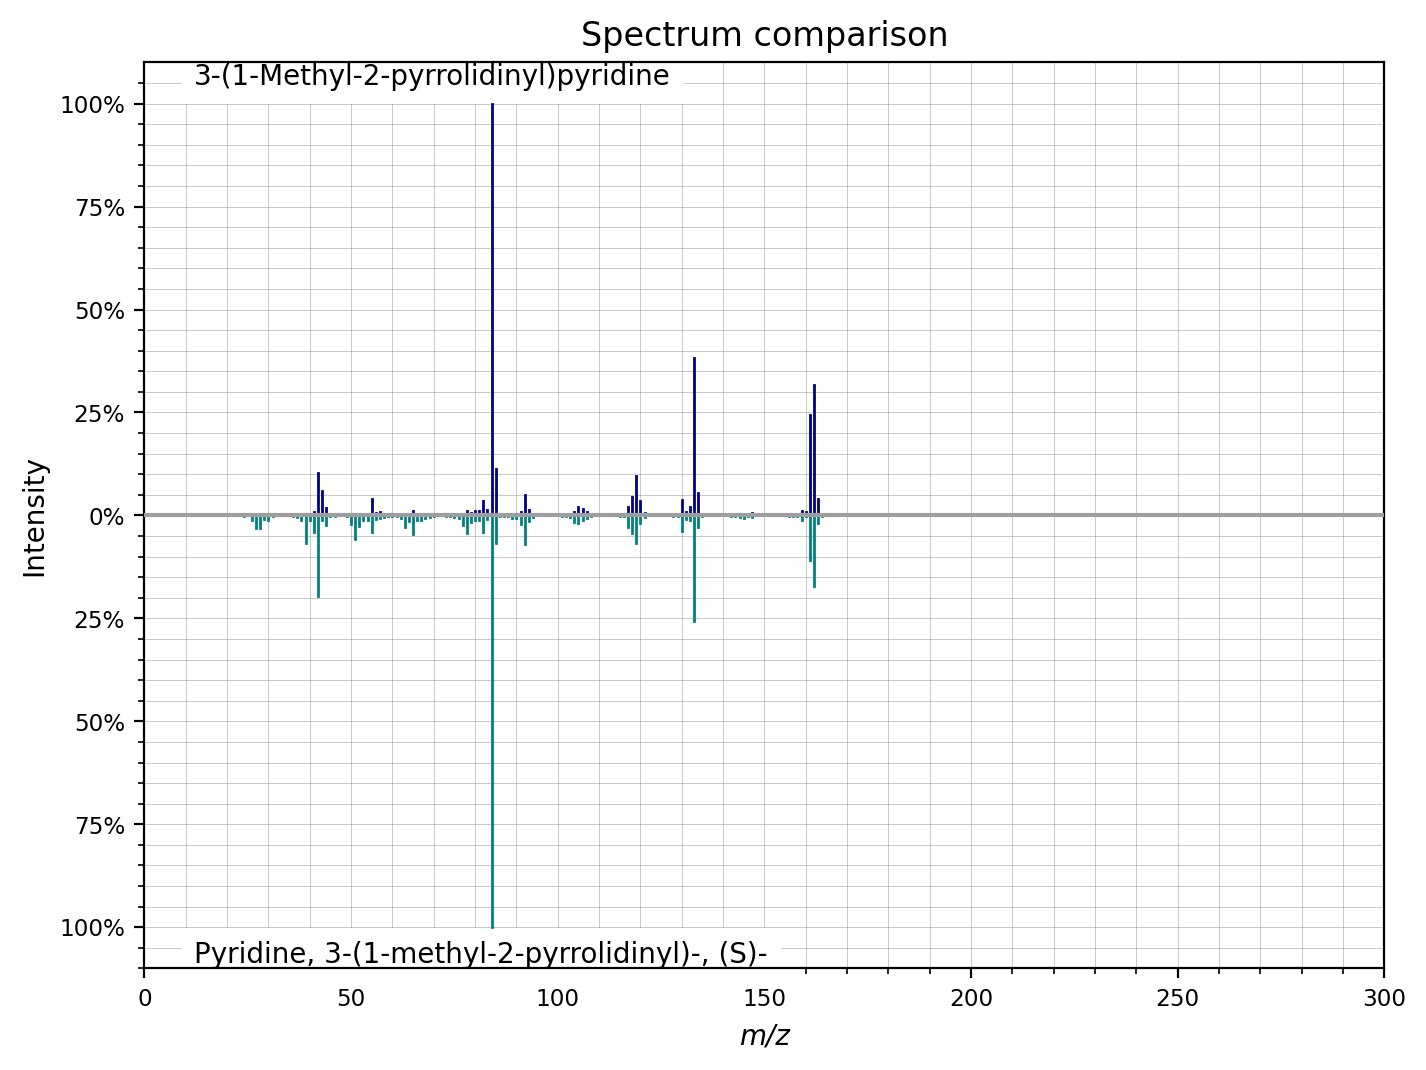

In [31]:
nist_dict["CN1CCCC1C2=CN=CC=C2"][0].plot_against(nist_dict["CN1CCCC1C2=CN=CC=C2"][3])

In [27]:
abundance = sorted(nist_dict.items(), key=lambda x:len(x[1]), reverse=True)

Here we can see the counts of duplicities in the spectrum dataset.

In [28]:
for i in range(20):
    print(f"Molecule {abundance[i][0]} has {len(abundance[i][1])} unique spectras in our dataset")

Molecule CC1CCC(C(C1)O)C(C)C has 24 unique spectras in our dataset
Molecule CC(C(C1=CC=CC=C1)O)N has 19 unique spectras in our dataset
Molecule C1(C(C(C(C(C1Cl)Cl)Cl)Cl)Cl)Cl has 19 unique spectras in our dataset
Molecule CC1CCC(C(=O)C1)C(C)C has 18 unique spectras in our dataset
Molecule CC(=O)OC1CC2CCC1(C2(C)C)C has 17 unique spectras in our dataset
Molecule CC(C)CCCC(C)C1CCC2C1(CCC3C2CCC4C3(CCC(C4)O)C)C has 17 unique spectras in our dataset
Molecule CC12CCC(CC1CCC3C2CCC4(C3CCC4=O)C)O has 16 unique spectras in our dataset
Molecule CC1(C2CCC1(C(C2)O)C)C has 15 unique spectras in our dataset
Molecule CC1CCC2C1C3C(C3(C)C)CCC2(C)O has 15 unique spectras in our dataset
Molecule C1CC2CC1CC2O has 14 unique spectras in our dataset
Molecule COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O has 14 unique spectras in our dataset
Molecule CCC=CCCO has 13 unique spectras in our dataset
Molecule CC(=CCCC(=CC=O)C)C has 13 unique spectras in our dataset
Molecule CC1(C2CCC1(C(=O)C2)C)C has 13 unique spectra

## NIST - a bit of data analysis

In [48]:
import numpy as np
from collections import Counter

In [72]:
nums_of_peaks = list(map(lambda x: len(x.mz), updated_dataset))
c = Counter(nums_of_peaks)

<BarContainer object of 552 artists>

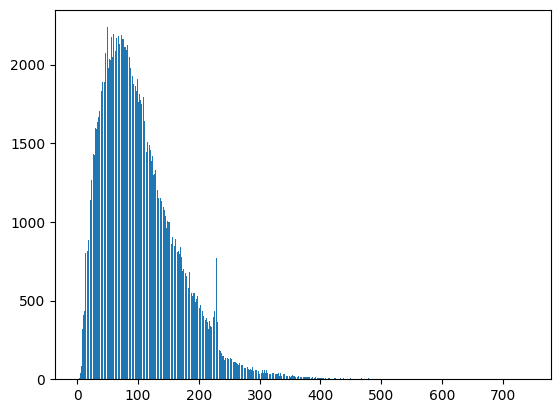

In [73]:
# visualize the following array as histogram
sorted_lens = np.array(sorted(list(c.items()), key=lambda x: x[0])).T
plt.bar(sorted_lens[0], sorted_lens[1])

In [77]:
len(list(filter(lambda x: x > 300, nums_of_peaks)))

2929

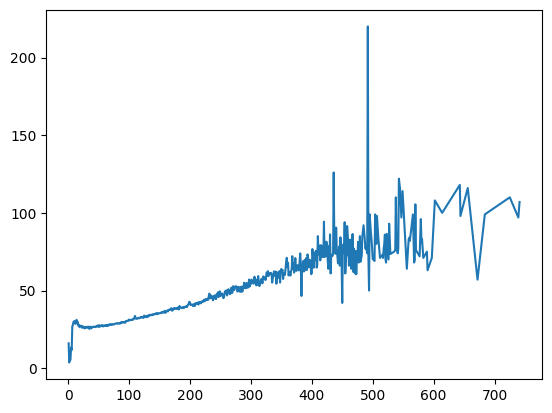

In [78]:
# create pairs of (num_peaks, smiles_length), then sort them by num_peaks (aggregate with average) and plot
nums_of_peaks = list(map(lambda x: len(x.mz), updated_dataset))
smiles_lens = list(map(lambda x: len(x.get("smiles")), updated_dataset))
pairs = list(zip(nums_of_peaks, smiles_lens))

pairs = sorted(pairs, key=lambda x: x[0])
pairs = np.array(pairs)
unique_peaks = np.unique(pairs[:, 0])
aggregated = np.array(list(map(lambda x: np.mean(pairs[pairs[:, 0] == x][:, 1]), unique_peaks)))

plt.plot(unique_peaks, aggregated)

In [79]:
pairs

array([[  1,  16],
       [  2,   4],
       [  2,   4],
       ...,
       [725, 110],
       [739,  97],
       [741, 107]])